In [159]:
import librosa
import librosa.display
import librosa.feature
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, train_test_split, KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import maad
from maad.features import temporal_entropy
import scipy
from scipy import signal
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

In [216]:
def main():
    # Locate all audio files from new testing samples folder
    all_audio_files = glob.glob("../microphone-sampling/NewTestingSamples/*/*")

    # Dictionary to store file names by class
    class_dict = {}
    for file in all_audio_files:
        file_class = file.split('/')[3]
        if file_class not in class_dict:
            class_dict[file_class] = []
        class_dict[file_class].append(file)

    # Extract all features for each class and store in dataframes
    all_class_dfs = []
    for key in class_dict:
        df = wav_to_audio_features(class_dict[key])
        df["Class"] = key
        all_class_dfs.append(df)

    all_audio_df = pd.concat(all_class_dfs)
    print(all_audio_df)

In [218]:
main()

     Avg_ACC   Avg_ZCR        Ht        Hf         ACI    SC_LFC    SC_MFC  \
0   0.001171  0.000000  0.999911  0.232813  168.031769  0.088979  0.134808   
1   0.000988  0.000280  0.999947  0.240220  164.089203  0.094047  0.132929   
2   0.001039  0.000280  0.999930  0.229874  165.546082  0.084607  0.132475   
3   0.002269  0.000000  0.999919  0.237859  162.925629  0.090740  0.137477   
4   0.000883  0.000000  0.999925  0.237461  134.975143  0.143793  0.137882   
..       ...       ...       ...       ...         ...       ...       ...   
16  0.001167  0.000679  0.990521  0.130692  134.761749  0.289332  0.321535   
17  0.020243  0.000164  0.992523  0.128226  134.184311  0.302018  0.324420   
18  0.000628  0.000215  0.993560  0.121316  135.694641  0.260214  0.253241   
19  0.000482  0.000386  0.993329  0.123558  137.844360  0.278943  0.275499   
20  0.229336  0.000137  0.993963  0.127541  133.491272  0.298277  0.321181   

      SC_HFC       Class  
0   0.111801  light_rain  
1   0.102

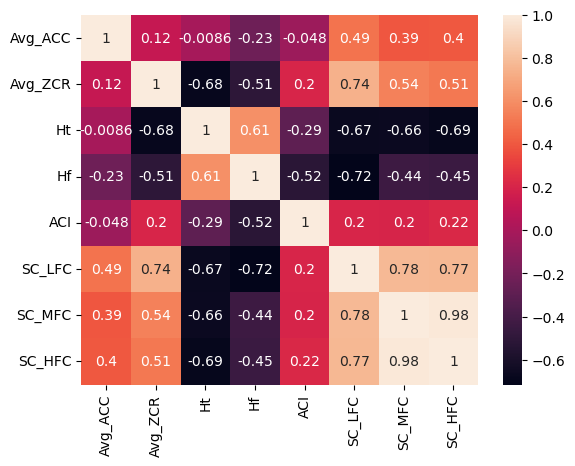

In [157]:
ax = sns.heatmap(features_df.corr(), annot=True)

In [147]:
def wav_to_audio_features(files):
    
    ACC_list = []
    ZCR_list = []
    Ht_list = []
    Hf_list = []
    ACI_list = []
    SC_LFC_list = [] 
    SC_MFC_list = []
    SC_HFC_list = []
    
    # os.listdir gets all files in the specified directory
    for filename in files:
        # Librosa/File setup
        x, sr = librosa.load(filename)

        # Get a spectrogram to use as the input to the spectral_entropy, ACI, and spectral cover functions
        # f is the array of sample frequencies
        # t is the array of segment times
        # sxx is a spectrogram of x (the audio signal, originally in the time domain
        f, t, sxx = scipy.signal.spectrogram(x, fs=sr)

        # Extracting Auto Correlation Coefficient
        acc = sm.tsa.acf(x, nlags=2000)
        ACC_list.append(np.mean(acc))

        # Extracting Zero Crossing Rate
        zero_crossings = librosa.feature.zero_crossing_rate(x, pad=False)
        fixed_length_zcr = librosa.util.fix_length(zero_crossings[0], size=1000, mode='edge')
        ZCR_list.append(np.mean(fixed_length_zcr))

        # Extracting Temporal Entropy (Ht)
        Ht = maad.features.temporal_entropy(x)
        Ht_list.append(Ht)

        # Extract Spectral Entropy (Hf)
        # Use EAS because that is the Entropy of Average Spectrum
        EAS, ECU, ECV, EPS, EPS_KURT, EPS_SKEW = maad.features.spectral_entropy(sxx, f)
        Hf = EAS
        Hf_list.append(Hf)

        # Acoustic Complexity Index (ACI) 
        # Use sxx from the spectrogram
        _, _, ACI = maad.features.acoustic_complexity_index(sxx)
        ACI_list.append(ACI)

        # Spectral Cover (SC)
        # Using the maad spectrogram for SC to get the ext variable,
        # to be able to get the spectrogram with no noise.
        sxx_power, tn, fn, ext = maad.sound.spectrogram(x, sr)
        sxx_no_noise = maad.sound.median_equalizer(sxx_power, display=False, extent=ext)
        sxx_dB_no_noise = maad.util.power2dB(sxx_no_noise)
        LFC, MFC, HFC = maad.features.spectral_cover(sxx_dB_no_noise, fn)
        SC_LFC_list.append(LFC)
        SC_MFC_list.append(MFC)
        SC_HFC_list.append(HFC)

    #Convert all lists into arrays to return and be used by
    ACC_array = np.array(ACC_list)
    ZCR_array = np.array(ZCR_list)
    Ht_array = np.array(Ht_list)
    Hf_array = np.array(Hf_list)
    ACI_array = np.array(ACI_list)
    SC_LFC_array = np.array(SC_LFC_list)
    SC_MFC_array = np.array(SC_MFC_list)
    SC_HFC_array = np.array(SC_HFC_list)

    # Create dataframe from all features
    features_dict = {"Avg_ACC": ACC_array, "Avg_ZCR": ZCR_array, "Ht": Ht_array, "Hf": Hf_array, "ACI": ACI_array, "SC_LFC": SC_LFC_array, 
                     "SC_MFC": SC_MFC_array, "SC_HFC": SC_HFC_array}
    features_df = pd.DataFrame(features_dict)
    
    return features_df